# Solucion de la ecuación de Poisson usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación

$$ \frac{d^2 u(x)}{d^2 x}  = f(x)\quad \forall x \in (0, \pi)$$

con $u(0) = u(\pi) = 0$.


## Aproximación de la función

En este caso tenemos una aproximación

$$u_\theta(x) \approx \operatorname{NN}(x; \theta)\, ,$$

dondee $\operatorname{NN}$ es una red neuronal con parámetros
entrenables $\theta$.

El residual para este problema estaría dado por

$$R(x) = \frac{d^2 u_\theta(x)}{d^2 x}  - f(x) \, .$$

Por el caracter no linealidad respecto a los parámetros
$\theta$ de las redes neuronales evaluar el residual
en una serie de puntos $x_i$  y forzarlo a ser cero
en estos puntos, llevaría a un sistema
no lineal de ecuaciones

$$R(x_i) = 0 \quad \forall x_i\, .$$

## Función de pérdida

Una alternativa a resolver el sistema de ecuaciones anteriormente
planteado es minimizar

$$\min_\theta \frac{1}{N}\sum_{i}^N |R(x_i)|^2 \, .$$

Que sería exactamente 0 si cada uno de los residuales es igual a 0.

A este problema le harían falta las condiciones de frontera. Para
esto se propone una función objetivo que las incluya

$$\min_\theta \frac{1}{N}\sum_{i}^N R(x_i)^2  + \lambda_1 u_\theta(0)^2
+ \lambda_2 u_\theta(\pi)^2\, .$$

## Ejemplo computacional

In [7]:
# Import required packages
using Lux                  # Neural network definition and training
using LuxCUDA
using TaylorDiff           # Automatic differentiation
using Optimization         # Optimization problem solving
using Optimisers           # Optimizers such as Adam
using Random               # Random number generation
using Plots                # Plotting utilities
using Zygote               # Automatic differentiation
using ComponentArrays      # Array utilities for handling model parameters
using Printf               # Advanced formatted printing
using LinearAlgebra        # Linear algebra operations
using Statistics           # Statistical operations
using OptimizationOptimisers  # Optimization extensions for Optimisers
using OptimizationOptimJL     # Optimization extensions for LBFGS

In [8]:
# Initial program setup
# Seeding for reproducibility
rng = Random.default_rng()
Random.seed!(rng, 0)

# Device configuration (CPU/GPU)
const DEVICE_CPU = cpu_device()  #  device cpu_device() gpu_device() 
const DEVICE_GPU = gpu_device()  #  device cpu_device() gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [9]:
# Data preparation
# Input range and target output
INPUT_RANGE = range(0, Float64.(pi), length=100)
input_data = Float64.(reshape(collect(INPUT_RANGE), 1, :) |> DEVICE_GPU)   # Input data
f_rhs(x) = reshape(Float64.(-4*sin.(2*x)), 1, :)  # f_rhs
data = input_data    # Move data to the selected device 

1×100 CuArray{Float64, 2, CUDA.DeviceMemory}:
 0.0  0.0317333  0.0634665  0.0951998  …  3.04639  3.07813  3.10986  3.14159

In [10]:
# Neural network definition
# Architecture: Network with multiple dense layers and tanh activation ; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros64
const HIDDEN_UNITS = 10
model = Chain(
    Dense(1 => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh; init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => HIDDEN_UNITS, tanh;  init_weight=Lux.glorot_uniform,init_bias=Lux.zeros32),
    Dense(HIDDEN_UNITS => 1; init_weight=Lux.glorot_uniform, init_bias=Lux.zeros32)
)

# Model initialization
params, states = Lux.setup(rng, model)  # Initial parameters and states
params = Float64.(ComponentArray(params) |> DEVICE_GPU)  # Move parameters to the device
states = states |> DEVICE_GPU  # Move states to the device
smodel = StatefulLuxLayer{true}(model, params, states)  # Stateful model layer

StatefulLuxLayer{true}(
    Chain(
        layer_1 = Dense(1 => 10, tanh),  # 20 parameters
        layer_2 = Dense(10 => 10, tanh),  # 110 parameters
        layer_3 = Dense(10 => 10, tanh),  # 110 parameters
        layer_4 = Dense(10 => 1),       # 11 parameters
    ),
)         # Total: 251 parameters,
          #        plus 0 states.

In [11]:
# Definir el valor de ε1 para el metodo de diferencias finitas
εmachine = eps(Float64)
ε2 = εmachine^(1/4)

function loss_adjoint(params, (input_data))
    # Predicción de la red neuronal
    f(input_data) = smodel(input_data, params)

    # Calcular la derivada numérica usando diferencias finitas centradas
    ddu(input_data)=Float64.((f(input_data .+ ε2) .- 2f0 .* f(input_data) .+ f(input_data .- ε2)) / (ε2^2))

    # Ressiduo de la ecuación diferencial
    res_eq = ddu(input_data) - f_rhs(input_data) 
    loss_eq = mean((res_eq).^2)  
    loss_bc = Array(((f([0] |> DEVICE_GPU) .- (0)).^2) + ((f([Float64.(pi)] |> DEVICE_GPU) .- (0)).^2))[1] 
    total_loss = loss_eq + loss_bc
    return total_loss
end

# Callback function
# Monitors training progress
function callback(state, l)
    state.iter % 100 == 1 && @printf "Iteration: %5d, Loss: %.12e\n" state.iter l
    return l < 1e-8  # Stop if loss is sufficiently small
end

callback (generic function with 1 method)

In [12]:
data = (input_data)  # Data tuple

# Definir el problema de optimización
opt_func = OptimizationFunction(loss_adjoint, Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, params, data)
iters = 5_01  # Número máximo de iteraciones

501

In [13]:
# Train using the Adam optimizer
res_adam = solve(opt_prob, Optimisers.Adam(1e-3), callback=callback, maxiters=iters)

┌ Warning: Mixed Precision Inputs received for `weight`: CuArray{Float64, 2, CUDA.DeviceMemory} and `x`: CuArray{Int64, 2, CUDA.DeviceMemory}. Promoting to Float64.
└ @ LuxLibCUDAExt /home/orincon/.julia/packages/LuxLib/ru5RQ/ext/LuxLibCUDAExt/cublaslt.jl:26


Iteration:     1, Loss: 8.085810961203e+00
Iteration:   101, Loss: 4.390117546484e+00
Iteration:   201, Loss: 1.944216641714e+00
Iteration:   301, Loss: 1.549366948674e+00
Iteration:   401, Loss: 8.773610595018e-01
Iteration:   501, Loss: 1.044709923808e-01


retcode: Default
u: ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:20, Axis(weight = ViewAxis(1:10, ShapedAxis((10, 1))), bias = 11:20)), layer_2 = ViewAxis(21:130, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_3 = ViewAxis(131:240, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_4 = ViewAxis(241:251, Axis(weight = ViewAxis(1:10, ShapedAxis((1, 10))), bias = 11:11)))}}}(layer_1 = (weight = [-0.5722165597264783; -0.7695775292807021; … ; -0.3913540319446252; -0.2749011299427649;;], bias = [0.22796291468549107, -0.09473863624994484, -0.3290377434588955, -0.23639681955391806, 0.4982180070799341, -0.20630334440000556, 0.04131221581310564, -0.39145832129076574, 0.11444794795487276, 0.4639168839557045]), layer_2 = (weight = [-0.13463947408964644 0.6534075040121574 … 0.3879361816137786 0.09323900690999878; 0.21978672222139217 0.015316817628445193 … 0.29723392152981665 0.39770459696523

In [14]:
# Redefine the optimization problem with updated parameters
opt_prob = OptimizationProblem(opt_func, res_adam.u, data)

# Further training using the LBFGS optimizer
res_lbfgs = solve(opt_prob, OptimizationOptimJL.LBFGS(); callback, maxiters=iters)

Iteration:     1, Loss: 9.287774344287e-02
Iteration:   101, Loss: 5.435939759280e-05
Iteration:   201, Loss: 3.649386525440e-05
Iteration:   301, Loss: 1.177367970625e-05
Iteration:   401, Loss: 8.244150365219e-06
Iteration:   501, Loss: 1.064423522867e-06


retcode: Failure
u: ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:20, Axis(weight = ViewAxis(1:10, ShapedAxis((10, 1))), bias = 11:20)), layer_2 = ViewAxis(21:130, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_3 = ViewAxis(131:240, Axis(weight = ViewAxis(1:100, ShapedAxis((10, 10))), bias = 101:110)), layer_4 = ViewAxis(241:251, Axis(weight = ViewAxis(1:10, ShapedAxis((1, 10))), bias = 11:11)))}}}(layer_1 = (weight = [-0.6758807768819438; -0.779208072622729; … ; -0.39844186447390156; -0.31185505536806146;;], bias = [0.14861358065248698, -0.10480503116870007, -0.3078496181751586, -0.24065428071487655, 0.7622806089923657, -0.18205716081231268, -0.003957057059432158, -0.500875750304717, 0.03095393635511934, 0.6477877414838531]), layer_2 = (weight = [-0.15463240856757057 0.6338197374245305 … 0.3742803552358693 0.08071954363521186; 0.19888596931191085 -0.016407870101180406 … 0.3139283312237705 0.4846502515268

In [15]:
# Make predictions with the optimized model
pred = smodel(input_data, res_adam.u)

1×100 CuArray{Float64, 2, CUDA.DeviceMemory}:
 -0.00883164  0.061768  0.13195  0.20146  …  -0.186282  -0.138973  -0.091595

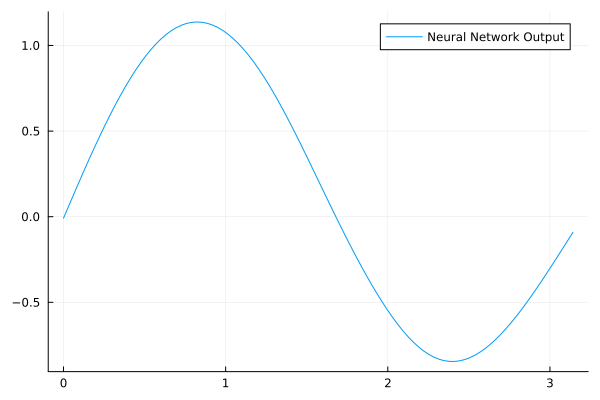

In [16]:
plot(Array(input_data)', Array(pred)', label="Neural Network Output")